Importe de los paquetes necesarios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [3]:
trips=pd.read_csv('BD_MachineLearning.csv')

Partiendo de la definición de demanda la cual hace referencia a la cantidad de bienes y/o servicios que los consumidores están dispuestos y pueden comprar a un precio determinado en un periodo de tiempo específico, la demanda de viajes en taxi en la ciudad de Nueva York es la cantidad de viajes es taxi registrados en un periodo especifico (días, meses, años, etc.), para el objetivo de este estudio se toman registros diarios, por loque se selecciona solo la variable ‘total_viajes’

In [4]:
trips.head()

,date,total_viajes,total_ecologicos,total_tradicionales,porcentaje_ecologicos,porcentaje_tradicionales,promedio_precio_ecologico,promedio_precio_tradicional,promedio_velocidad_ecologica,promedio_velocidad_tradicional
0,2024-08-30,4,0,4,0.00,100.00,NaN,24.06,NaN,0.24
1,2024-08-29,88211,1599,86612,1.81,98.19,24.29,24.05,0.75,0.31
2,2024-08-28,93261,1593,91668,1.71,98.29,24.47,23.47,0.29,0.24
3,2024-08-27,84401,1525,82876,1.81,98.19,23.77,23.46,0.31,0.30
4,2024-08-26,75182,1550,73632,2.06,97.94,23.54,23.30,0.23,0.30


In [6]:
trips.shape

(1338, 10)

In [11]:
time_serie=trips[['date', 'total_viajes']]

Conversión a ‘datetype’ de la columna ‘date’, se organiza de manera ascendente la serie de tiempo y se hace un reset del índice.

In [12]:
time_serie['date']=pd.to_datetime(time_serie['date'])
time_serie=time_serie.sort_values(by='date')
time_serie=time_serie.reset_index(drop=True)

C:\Users\57319\AppData\Local\Temp\ipykernel_6416\2517864370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_serie['date']=pd.to_datetime(time_serie['date'])


Verificación de que no existan fechas faltantes.

In [16]:
existing_dates=set(time_serie['date'])
full_date_range = pd.date_range(start='2021-01-01', end='2024-08-30')
all_dates=set(full_date_range)
missing_dates=all_dates-existing_dates
print(missing_dates)

set()


EDA

Primeras filas

In [17]:
time_serie.head()

,date,total_viajes
0,2021-01-01,23976
1,2021-01-02,33717
2,2021-01-03,25409
3,2021-01-04,43716
4,2021-01-05,46084


informacion general de la serie de tiempo

In [18]:
time_serie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1338 non-null   datetime64[ns]
 1   total_viajes  1338 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 21.0 KB


Descripción estadística de la columna 'total_viajes' 

In [19]:
print(time_serie['total_viajes'].describe())

count      1338.000000
mean      94560.115097
std       21369.847581
min           4.000000
25%       83268.250000
50%       96727.500000
75%      110185.500000
max      132600.000000
Name: total_viajes, dtype: float64


Grafico de la serie de tiempo.

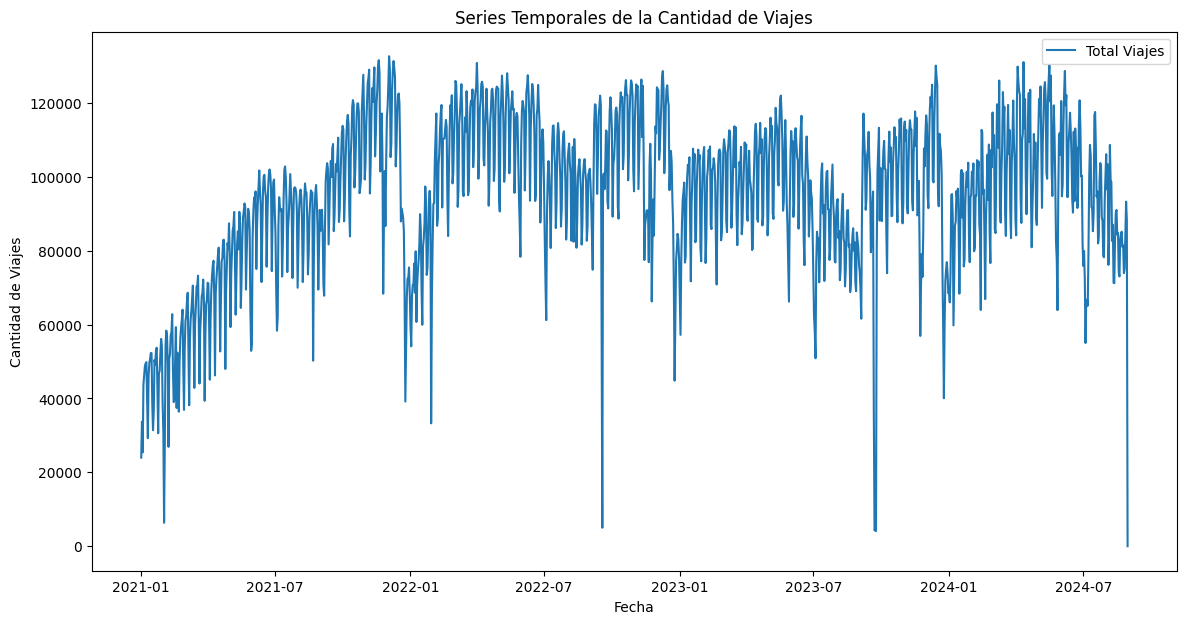

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(time_serie['date'], time_serie['total_viajes'], label='Total Viajes')
plt.title('Series Temporales de la Cantidad de Viajes')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Viajes')
plt.legend()
plt.show()

Distribucion de la cantidad de viajes

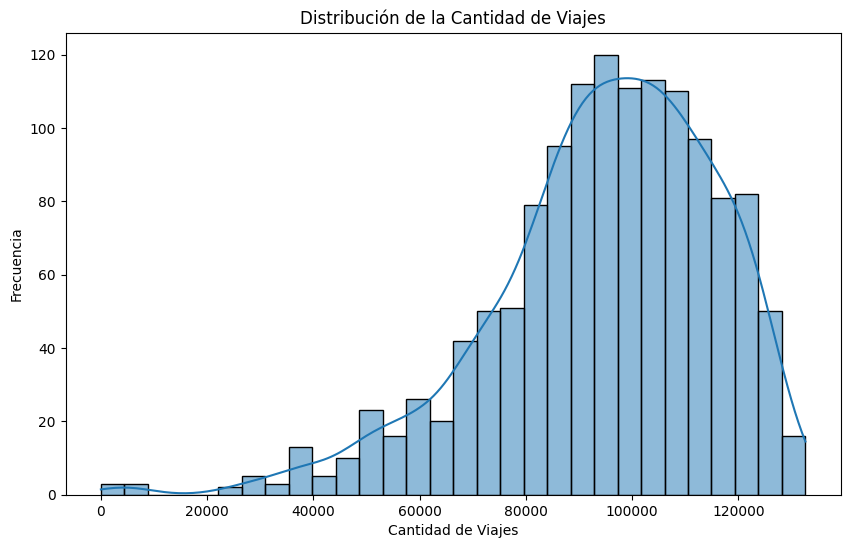

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(time_serie['total_viajes'], bins=30, kde=True)
plt.title('Distribución de la Cantidad de Viajes')
plt.xlabel('Cantidad de Viajes')
plt.ylabel('Frecuencia')
plt.show()


En base a la grafica de la distribucion de crea un dataframe con cantidad de viajes inferior a 20000, que seria los outliers a remplazar antes de entrenar modelos

In [31]:
time_serie_filtrado=time_serie[time_serie['total_viajes']< 20000]

In [32]:
time_serie_filtrado.shape

(6, 1)

In [33]:
time_serie_filtrado

,total_viajes
date,
2021-02-01,6347
2022-09-18,5003
2023-09-22,4271
2023-09-23,4711
2023-09-24,4101
2024-08-30,4


Esos 6 datos menores a 20000 se remplazaran por la media de la serie

Analisis de tendencias y estacionalidad

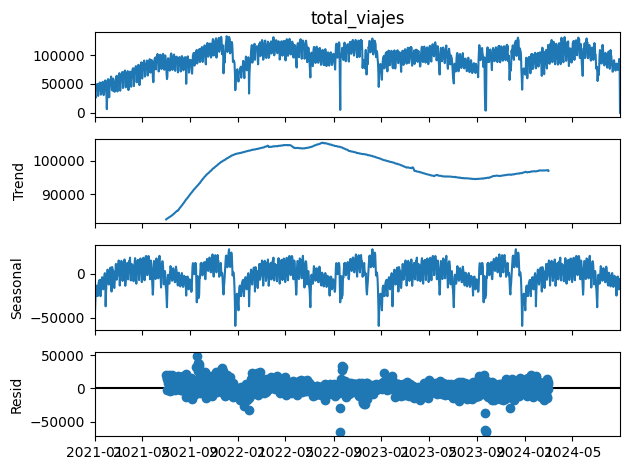

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

#  Columna 'date' como índice del DataFrame
time_serie.set_index('date', inplace=True)

# Descomposición de la serie temporal
decomposition = seasonal_decompose(time_serie['total_viajes'], model='additive', period=365)
decomposition.plot()
plt.show()

El primer grafico es el grafico de la serie de tiempo. 

La tendencia (Trend) representa la dirección a largo plazo de la serie temporal.

Estacionalidad (Seasonal) captura patrones repetitivos y predecibles que ocurren a intervalos regulares, por ejemplo aumento de viajes en determinado mes.

El ruido o residuo (Resid) son componentes aleatorios no explicados por la tendencia (trand) y la estacionalidad (seasonal)


Correlacion y auto-correlacion.

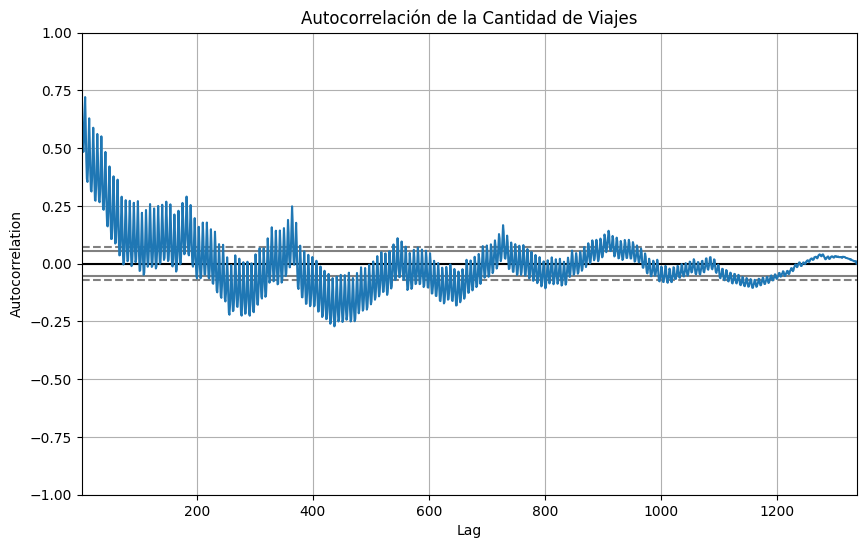

In [23]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(10, 6))
autocorrelation_plot(time_serie['total_viajes'])
plt.title('Autocorrelación de la Cantidad de Viajes')
plt.show()

Los valores altos y positivos indican que la serie esta altamente correlacionada con los valores pasados, los valores negativos indican correlación inversa, la grafica sugiere que hay tendencia a largo plazo en los datos puesto que la correlación decae lentamente.

El gráfico muestra una serie de oscilaciones en los valores de autocorrelación, con picos y valles que disminuyen en amplitud a medida que el lag aumenta. Esto indica que hay patrones repetitivos en los datos que se desvanecen a medida que aumenta el tiempo.

Las líneas horizontales discontinuas alrededor de la línea de autocorrelación cero representan los intervalos de confianza. Si los valores de autocorrelación están dentro de estos intervalos, significa que las correlaciones no son estadísticamente significativas.

Las oscilaciones indican la presencia de patrones cíclicos en los datos. Por ejemplo, si ves picos a intervalos regulares, esto sugiere una estacionalidad o periodicidad en los viajes.

La disminución en la amplitud de las oscilaciones a medida que aumenta el lag indica que la influencia de los valores pasados se reduce con el tiempo.

Ahora se remplazan los valores menores a 20000 por el promedio de la serie

In [34]:
mean_value = time_serie['total_viajes'].mean()
time_serie['total_viajes'] = time_serie['total_viajes'].apply(
    lambda x: mean_value if x < 20000 else x
)

Se observa de nuevo la distribucion de la cantidad de vijes por dia.

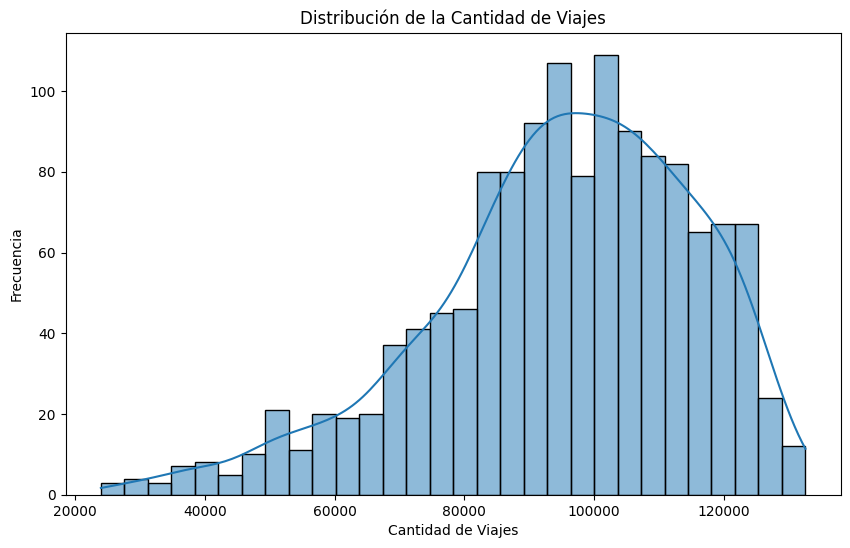

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(time_serie['total_viajes'], bins=30, kde=True)
plt.title('Distribución de la Cantidad de Viajes')
plt.xlabel('Cantidad de Viajes')
plt.ylabel('Frecuencia')
plt.show()

In [46]:
time_serie.reset_index(inplace=True)
time_serie['date'] = pd.to_datetime(time_serie['date'])

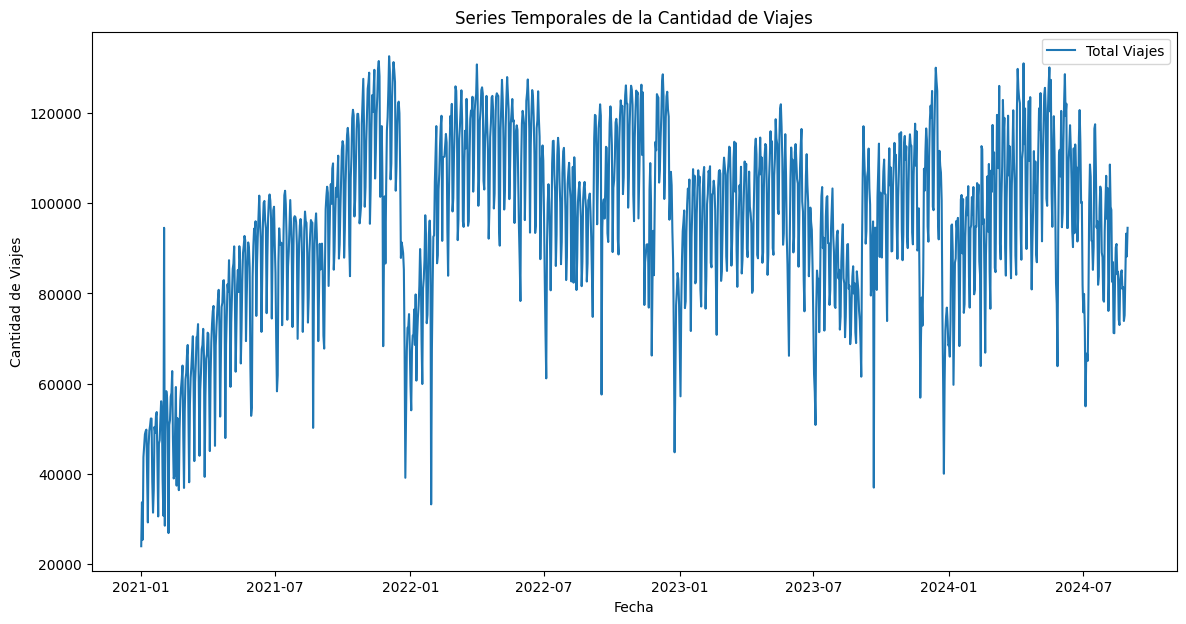

In [51]:
plt.figure(figsize=(14, 7))
plt.plot(time_serie['date'], time_serie['total_viajes'], label='Total Viajes')
plt.title('Series Temporales de la Cantidad de Viajes')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Viajes')
plt.legend()
plt.show()

Como se observva al remplazar los 6 valores atipicos mejoro la distribucion de los datos y en la serie de tiempo no hay valores atipicos

Ahora se van a ejecutar dos modelos de series de tiempo (ARIMA VAR) para decidir con cual se entrena la prediccion de la demanda

In [54]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller

Test de Dickey-Fuller para evaluar estacionalidad.

In [ ]:
result = adfuller(time_serie['total_viajes'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:', key, value)


ADF Statistic: -3.912242842940098
p-value: 0.0019465713712377287
Critical Values: 1% -3.4353288002925315
Critical Values: 5% -2.863738738939919
Critical Values: 10% -2.5679406189198177


Interpretacion de resultados:
La prueba de Dickey-Fuller  (ADF) se utiliza para verificar la estacionariedad de una serie temporal. Los elementos clave son:

Interpretación
1. ADF Statistic
El valor de la estadística ADF es -3.912242842940098. Este valor se compara con los valores críticos para determinar la estacionariedad.

2. p-value
El p-value es 0.0019465713712377287. Este valor indica la probabilidad de obtener un resultado al menos tan extremo como el observado, bajo la hipótesis nula de que la serie temporal no es estacionaria.

3. Critical Values
Los valores críticos proporcionan puntos de referencia para la estadística ADF en diferentes niveles de significancia:

1%: -3.4353288002925315

5%: -2.863738738939919

10%: -2.5679406189198177

Conclusión
Para determinar si la serie temporal es estacionaria, comparamos la estadística ADF con los valores críticos y evaluamos el p-value.

Comparación con Valores Críticos:

La estadística ADF (-3.912242842940098) es menor que todos los valores críticos en los niveles del 1%, 5% y 10%.

Esto sugiere que podemos rechazar la hipótesis nula de no estacionariedad.

Evaluación del p-value:

El p-value (0.0019465713712377287) es muy bajo (menor a 0.05), lo que refuerza la evidencia contra la hipótesis nula.

Conclusión Final
La serie temporal es estacionaria. La prueba ADF sugiere que la serie temporal no tiene una raíz unitaria y es estacionaria, ya que tanto la estadística ADF como el p-value nos permiten rechazar la hipótesis nula de no estacionariedad.

Esto significa que podemos proceder con la modelización de la serie temporal, como ajustar un modelo ARIMA, sin necesidad de diferenciar la serie adicionalmente para hacerla estacionaria.

In [ ]:
def evaluate_arima_model(X, arima_order):
    # Preparar la serie de tiempo
    X = X.astype('float32')
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    
    # Ajustar el modelo ARIMA
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    aic = model_fit.aic
    return aic

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    aic = evaluate_arima_model(dataset, order)
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print(f'ARIMA{order} AIC={aic:.3f}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} AIC={best_score:.3f}')
    return best_cfg

# Valores de p, d y q a probar
p_values = range(0, 6)
d_values = range(0, 2)  # d = 1 para diferenciar una vez según ADF
q_values = range(0, 6)

# Carga de datos
time_serie['date'] = pd.to_datetime(time_serie['date'])
time_serie.set_index('date', inplace=True)

# Encontrar los mejores parámetros
best_params = evaluate_models(time_serie['total_viajes'], p_values, d_values, q_values)

print(f'Los mejores parámetros ARIMA son: {best_params}')


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) AIC=30753.323


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1) AIC=23687.951


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 2) AIC=23480.554


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 3) AIC=23530.827


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 4) AIC=23458.632


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 5) AIC=23426.186
ARIMA(0, 1, 0) AIC=23146.005
ARIMA(0, 1, 1) AIC=23144.805


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(0, 1, 2) AIC=22956.554


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 3) AIC=22921.445


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 4) AIC=22918.949


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 5) AIC=22916.252
ARIMA(1, 0, 0) AIC=23085.648


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(1, 0, 1) AIC=23084.775


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) AIC=22976.568


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 3) AIC=22933.368


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 4) AIC=22934.564


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 5) AIC=22930.401
ARIMA(1, 1, 0) AIC=23146.233


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(1, 1, 1) AIC=22970.940


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2) AIC=22945.701


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 3) AIC=22915.315


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 4) AIC=22910.387


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 5) AIC=22911.560
ARIMA(2, 0, 0) AIC=23085.608


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 0, 1) AIC=23084.689


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(2, 0, 2) AIC=22947.694


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3) AIC=22941.603


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 4) AIC=22922.237


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 5) AIC=22920.150
ARIMA(2, 1, 0) AIC=23100.268


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 1, 1) AIC=22911.010


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(2, 1, 2) AIC=22785.360


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\b

ARIMA(2, 1, 3) AIC=22583.909


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 4) AIC=22602.522


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 5) AIC=22596.726
ARIMA(3, 0, 0) AIC=23067.360


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 1) AIC=22931.499


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(3, 0, 2) AIC=22916.744


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 3) AIC=22580.855


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 4) AIC=22633.516


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 5) AIC=22612.628
ARIMA(3, 1, 0) AIC=23043.450


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 1) AIC=22889.541


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\b

ARIMA(3, 1, 2) AIC=22677.086


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 3) AIC=22582.522
ARIMA(3, 1, 4) AIC=22610.501


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\t

ARIMA(3, 1, 5) AIC=22606.397
ARIMA(4, 0, 0) AIC=23031.031


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 1) AIC=22902.277


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(4, 0, 2) AIC=22942.084


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 3) AIC=22564.249


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\t

ARIMA(4, 0, 4) AIC=22624.437


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 5) AIC=22621.921
ARIMA(4, 1, 0) AIC=22967.715


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 1) AIC=22843.203


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(4, 1, 2) AIC=22547.789


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 3) AIC=22676.638


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 4) AIC=22549.851


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 5) AIC=22410.229
ARIMA(5, 0, 0) AIC=22971.154


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 1) AIC=22858.003


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(5, 0, 2) AIC=22898.963


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 3) AIC=22542.292


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 4) AIC=22575.527


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 5) AIC=22429.899
ARIMA(5, 1, 0) AIC=22759.627


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 1) AIC=22727.455


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\57319\AppData\Roaming\Python\Python312\site-packa

ARIMA(5, 1, 2) AIC=22529.516


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 3) AIC=22515.338


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 4) AIC=22392.547
ARIMA(5, 1, 5) AIC=22380.452
Best ARIMA(5, 1, 5) AIC=22380.452
Los mejores parámetros ARIMA son: (5, 1, 5)


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           total_viajes   No. Observations:                 1338
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -14008.776
Date:                Wed, 20 Nov 2024   AIC                          28039.553
Time:                        18:51:26   BIC                          28096.733
Sample:                    01-01-2021   HQIC                         28060.977
                         - 08-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5147      0.078      6.591      0.000       0.362       0.668
ar.L2         -1.2068      0.065    -18.677      0.000      -1.333      -1.080
ar.L3          0.3779      0.114      3.323      0.0

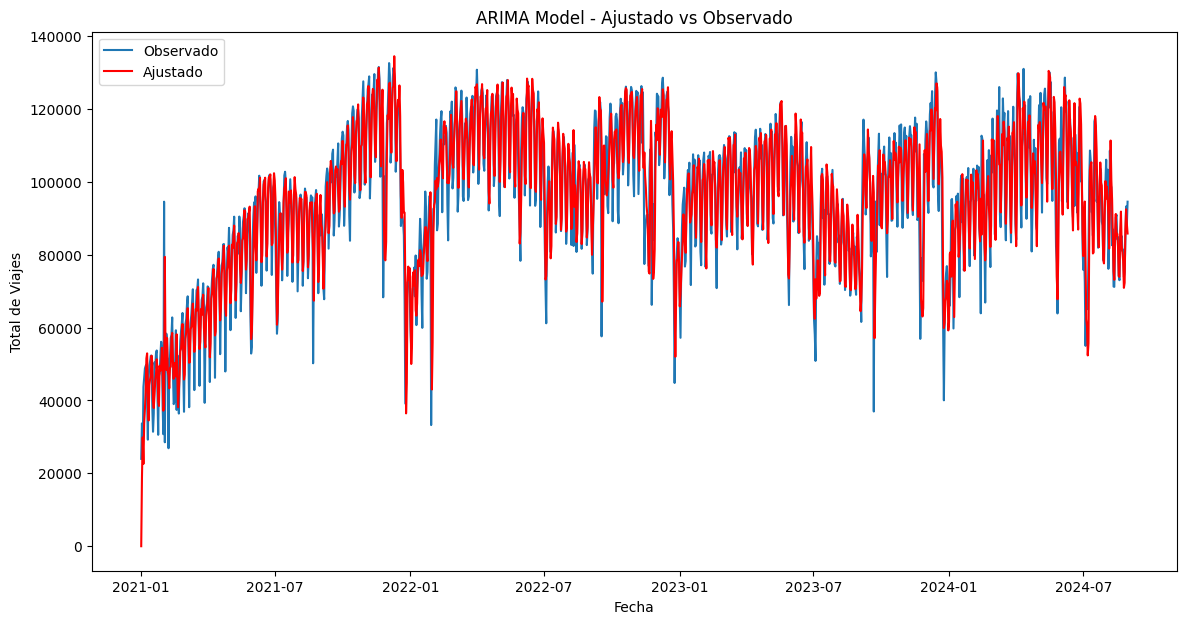

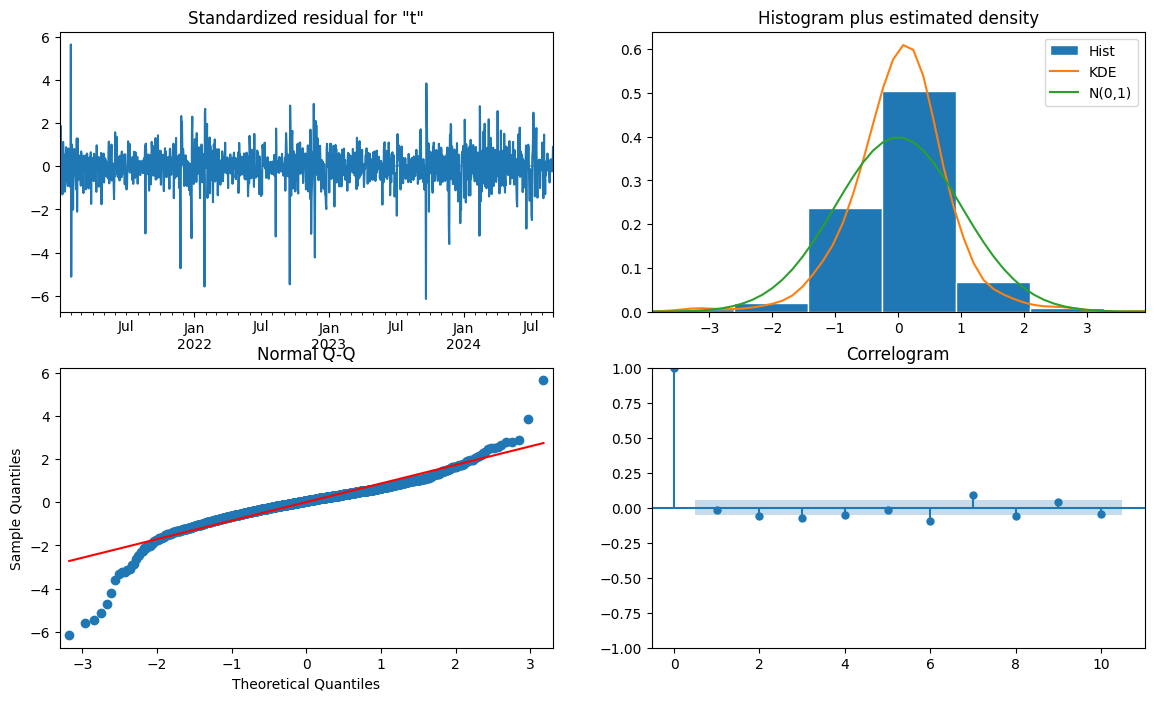

In [ ]:

# Ajuste del modelo ARIMA con los mejores parámetros
best_p, best_d, best_q = best_params
arima_model = ARIMA(time_serie['total_viajes'], order=(best_p, best_d, best_q))
arima_result = arima_model.fit()

# Resumen del modelo
print(arima_result.summary())

# Graficar los resultados del modelo ARIMA
plt.figure(figsize=(14, 7))
plt.plot(time_serie['total_viajes'], label='Observado')
plt.plot(arima_result.fittedvalues, color='red', label='Ajustado')
plt.title('ARIMA Model - Ajustado vs Observado')
plt.xlabel('Fecha')
plt.ylabel('Total de Viajes')
plt.legend()
plt.show()

# Gráficos de Diagnóstico
arima_result.plot_diagnostics(figsize=(14, 8))
plt.show()


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valores del pronóstico para los próximos 7 días:
                Fecha    Pronóstico  Confianza Inferior  Confianza Superior
2024-08-31 2024-08-31  88028.989438        68868.620338       107189.358539
2024-09-01 2024-09-01  79941.990044        57580.683900       102303.296188
2024-09-02 2024-09-02  78841.985617        53113.718034       104570.253200
2024-09-03 2024-09-03  91111.012553        62747.565686       119474.459420
2024-09-04 2024-09-04  97819.524299        66963.123563       128675.925034
2024-09-05 2024-09-05  94059.645432        61048.092096       127071.198768
2024-09-06 2024-09-06  91820.137013        56609.499825       127030.774202


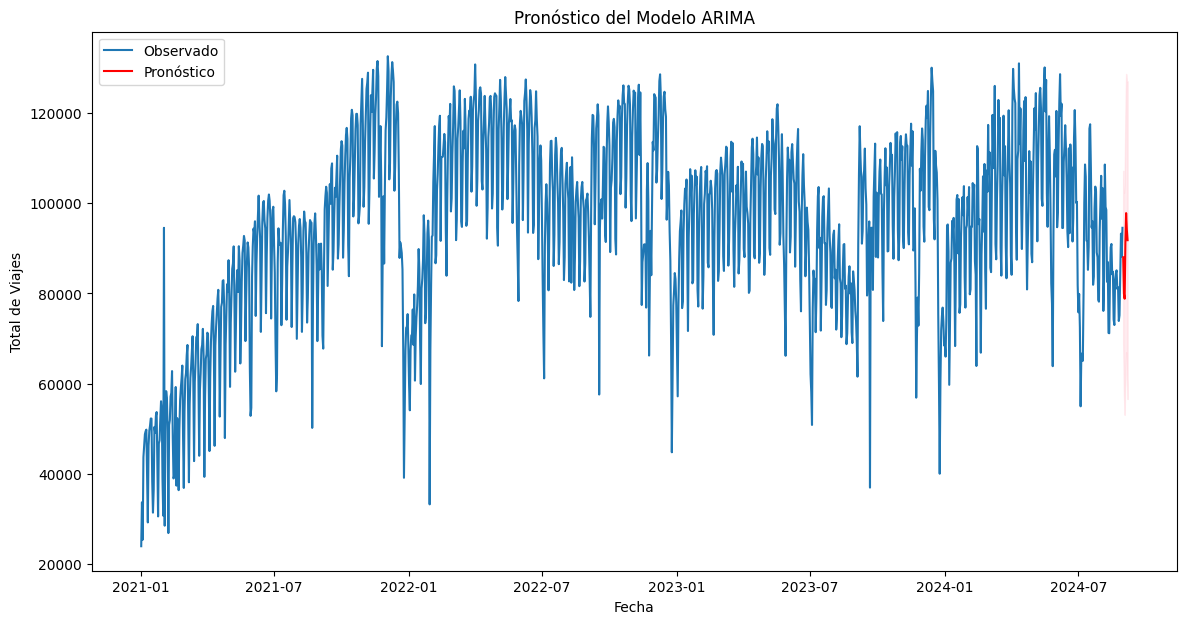

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


time_serie.reset_index(inplace=True)
time_serie['date'] = pd.to_datetime(time_serie['date'])
time_serie.set_index('date', inplace=True)

# Ajustar el modelo ARIMA con los mejores parámetros
best_p, best_d, best_q = 5, 1, 5  
arima_model = ARIMA(time_serie['total_viajes'], order=(best_p, best_d, best_q))
arima_result = arima_model.fit()

# Pronostico para los próximos 7 días
forecast_steps = 10
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=time_serie.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# DataFrame con los resultados del pronóstico
forecast_df = pd.DataFrame({
    'Fecha': forecast_index,
    'Pronóstico': forecast_values,
    'Confianza Inferior': forecast_ci.iloc[:, 0],
    'Confianza Superior': forecast_ci.iloc[:, 1]
})

print("Valores del pronóstico para los próximos 10 días:")
print(forecast_df)

# Crear el gráfico de pronóstico
plt.figure(figsize=(14, 7))
plt.plot(time_serie.index, time_serie['total_viajes'], label='Observado')
plt.plot(forecast_index, forecast_values, color='red', label='Pronóstico')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Pronóstico del Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Total de Viajes')
plt.legend()
plt.show()


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\states

Error Cuadrático Medio (MSE): 16510604.407553574


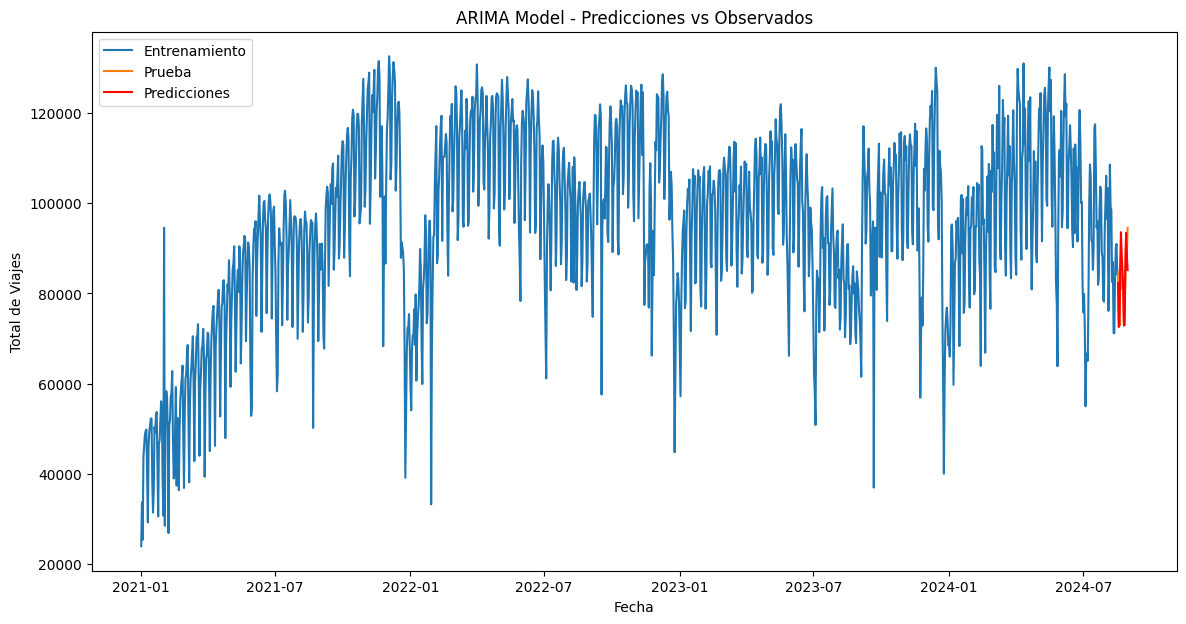

In [75]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Asegurarse de que la columna 'date' esté en formato datetime
time_serie.reset_index(inplace=True)
time_serie['date'] = pd.to_datetime(time_serie['date'])
time_serie.set_index('date', inplace=True)

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(time_serie) * 0.99)
train, test = time_serie.iloc[:train_size], time_serie.iloc[train_size:]

# Ajustar el modelo ARIMA con los mejores parámetros en el conjunto de entrenamiento
best_p, best_d, best_q = 5, 1, 5  # Ajusta estos valores según los mejores parámetros encontrados
arima_model = ARIMA(train['total_viajes'], order=(best_p, best_d, best_q))
arima_result = arima_model.fit()

# Hacer predicciones en el conjunto de prueba
start = len(train)
end = len(train) + len(test) - 1
predictions = arima_result.predict(start=start, end=end, typ='levels')

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test['total_viajes'], predictions)
print(f"Error Cuadrático Medio (MSE): {mse}")

# Graficar las predicciones frente a los valores observados
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['total_viajes'], label='Entrenamiento')
plt.plot(test.index, test['total_viajes'], label='Prueba')
plt.plot(test.index, predictions, color='red', label='Predicciones')
plt.title('ARIMA Model - Predicciones vs Observados')
plt.xlabel('Fecha')
plt.ylabel('Total de Viajes')
plt.legend()
plt.show()


Grafico de los pronosticos frente a los valores observados en el conjunto de prueba

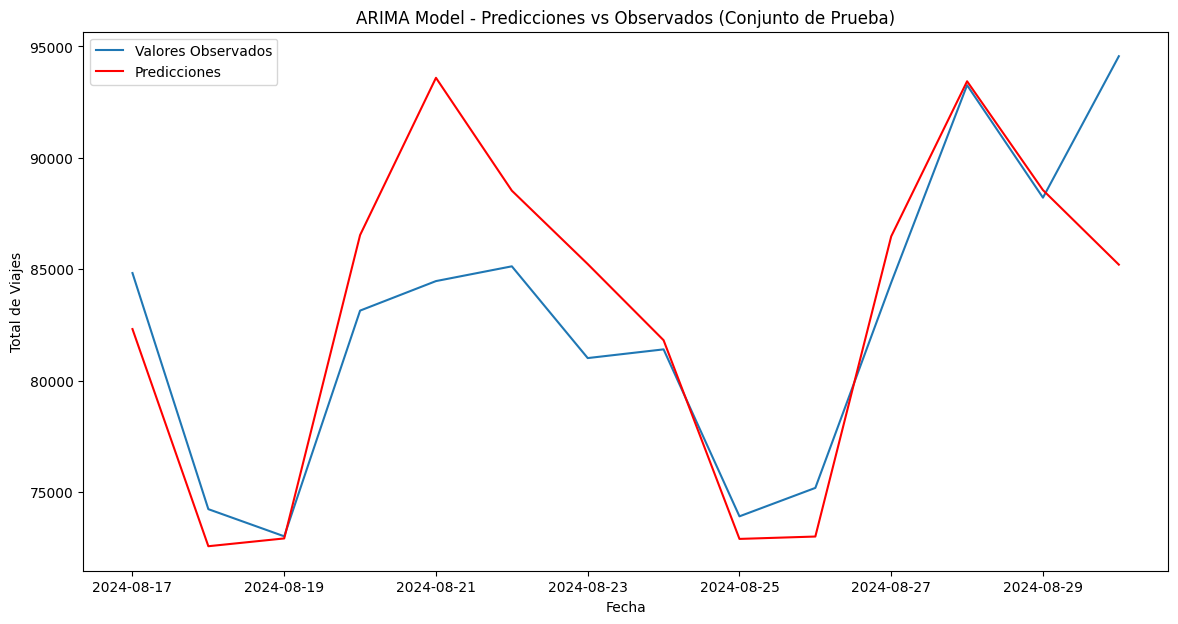

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['total_viajes'], label='Valores Observados')
plt.plot(test.index, predictions, color='red', label='Predicciones')
plt.title('ARIMA Model - Predicciones vs Observados (Conjunto de Prueba)')
plt.xlabel('Fecha')
plt.ylabel('Total de Viajes')
plt.legend()
plt.show()

In [79]:
time_serie.reset_index(inplace=True)
time_serie.head()

,date,total_viajes
0,2021-01-01,23976.0
1,2021-01-02,33717.0
2,2021-01-03,25409.0
3,2021-01-04,43716.0
4,2021-01-05,46084.0


Para realizar el ajuste del modelo VAR, se necesitan almenos dos variables, por lo que se utilizaran los residuos del modelo ARIMA (5, 1, 5). El primer paso es obtener los residuos

In [80]:
# Asegurarse de que la columna 'date' esté en formato datetime
time_serie['date'] = pd.to_datetime(time_serie['date'])
time_serie.set_index('date', inplace=True)

# Ajustar el modelo ARIMA(5, 1, 5)
arima_model = ARIMA(time_serie['total_viajes'], order=(5, 1, 5))
arima_result = arima_model.fit()

# Obtener los residuos del modelo ARIMA
time_serie['residuos_arima'] = arima_result.resid


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
time_serie.dropna()
time_serie.head()

,total_viajes,residuos_arima
date,,
2021-01-01,23976.0,23976.000000
2021-01-02,33717.0,14932.750336
2021-01-03,25409.0,-4450.974183
2021-01-04,43716.0,21130.029566
2021-01-05,46084.0,12305.988056


In [88]:
# Crear el DataFrame multivariante con total_viajes y residuos_arima
multivariate_df = time_serie[['total_viajes', 'residuos_arima']].dropna()

# Ajustar el modelo VAR
var_model = VAR(multivariate_df)
var_result = var_model.fit(maxlags=15, ic='aic')

# Resumen del modelo
print(var_result.summary())


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Nov, 2024
Time:                     20:25:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    26.2000
Nobs:                     1323.00    HQIC:                   26.0481
Log likelihood:          -20863.0    FPE:                1.87481e+11
AIC:                      25.9569    Det(Omega_mle):     1.78995e+11
--------------------------------------------------------------------
Results for equation total_viajes
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                   5891.084727      1428.255270            4.125           0.000
L1.total_viajes            1.534553         4.044362            0.379           0.704
L1.residuos_arima         -0.9616

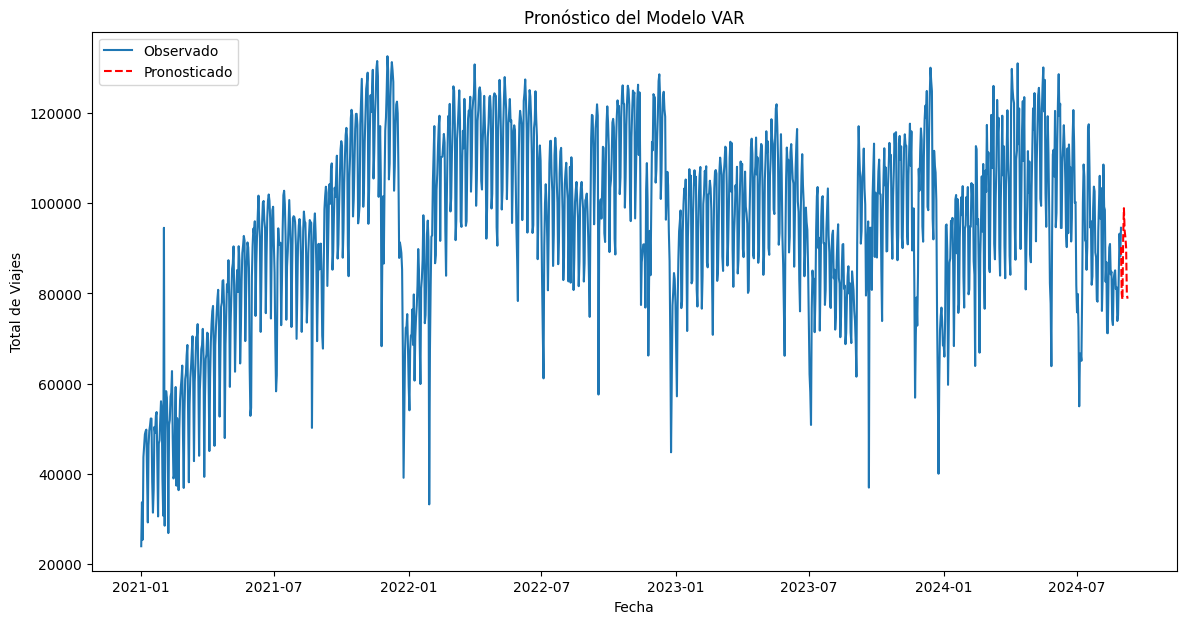

In [89]:
# Pronóstico
lag_order = var_result.k_ar
forecast_input = multivariate_df.values[-lag_order:]
forecast = var_result.forecast(y=forecast_input, steps=10)
forecast_index = pd.date_range(start=multivariate_df.index[-1], periods=10, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=multivariate_df.columns)

# Graficar el pronóstico
plt.figure(figsize=(14, 7))
plt.plot(multivariate_df.index, multivariate_df['total_viajes'], label='Observado')
plt.plot(forecast_df.index, forecast_df['total_viajes'], color='red', label='Pronosticado', linestyle='--')
plt.title('Pronóstico del Modelo VAR')
plt.xlabel('Fecha')
plt.ylabel('Total de Viajes')
plt.legend()
plt.show()


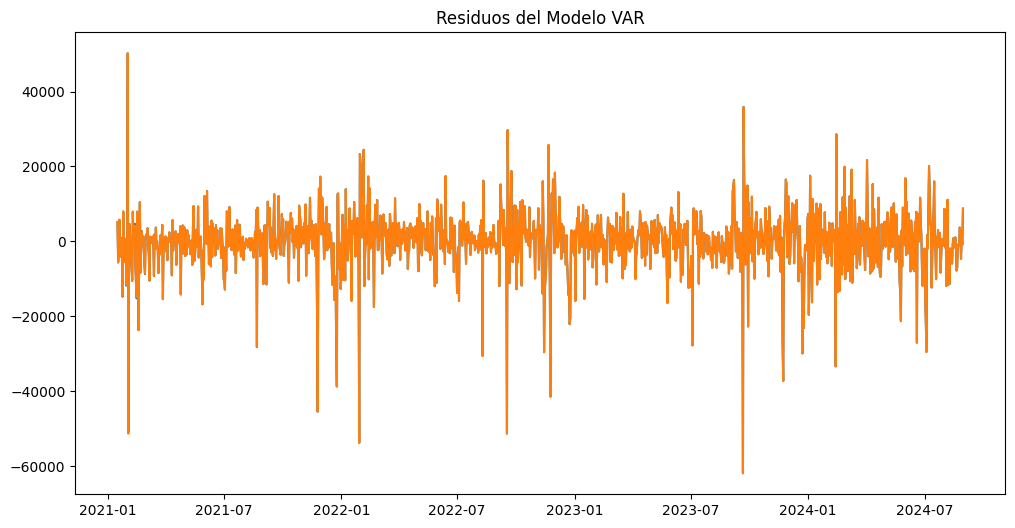

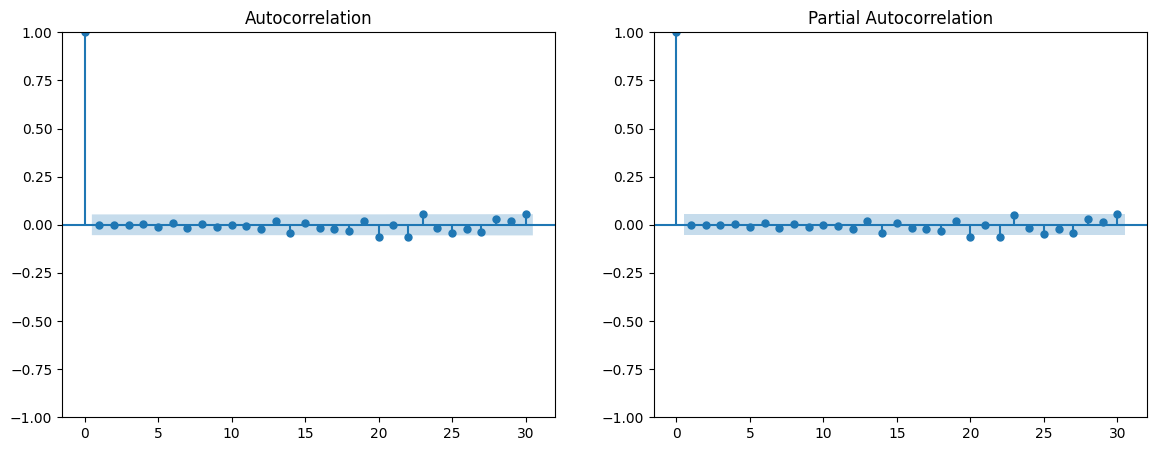

In [90]:
# Gráfico de residuos del modelo VAR
residuals = var_result.resid
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(residuals)
ax.set_title('Residuos del Modelo VAR')

# Autocorrelación de los residuos del modelo VAR
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sm.graphics.tsa.plot_acf(residuals['total_viajes'], lags=30, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals['total_viajes'], lags=30, ax=axes[1])
plt.show()


C:\Users\57319\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Error Cuadrático Medio (MSE) del Modelo VAR: 51382184.326341555


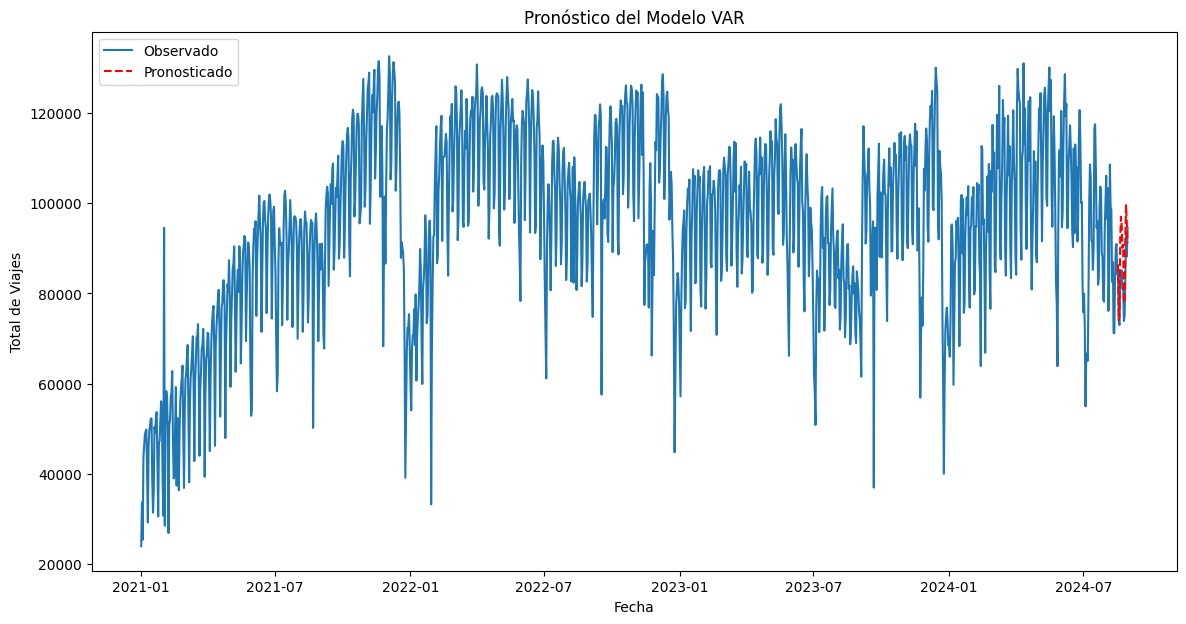

In [93]:
# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(multivariate_df) * 0.99)
train, test = multivariate_df.iloc[:train_size], multivariate_df.iloc[train_size:]

# Ajustar el modelo VAR en el conjunto de entrenamiento
var_model = VAR(train)
var_result = var_model.fit(maxlags=15, ic='aic')

# Hacer predicciones en el conjunto de prueba
lag_order = var_result.k_ar
forecast_input = train.values[-lag_order:]
forecast = var_result.forecast(y=forecast_input, steps=len(test))
forecast_index = test.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=multivariate_df.columns)

# Calcular el MSE
mse = mean_squared_error(test['total_viajes'], forecast_df['total_viajes'])
print(f"Error Cuadrático Medio (MSE) del Modelo VAR: {mse}")

# Graficar los valores observados y el pronóstico
plt.figure(figsize=(14, 7))
plt.plot(multivariate_df.index, multivariate_df['total_viajes'], label='Observado')
plt.plot(forecast_df.index, forecast_df['total_viajes'], color='red', label='Pronosticado', linestyle='--')
plt.title('Pronóstico del Modelo VAR')
plt.xlabel('Fecha')
plt.ylabel('Total de Viajes')
plt.legend()
plt.show()


debido a que el error cuadratico medio es menor para el modelo ARIMA se selecciona este para la implementacion del mismo